# Solving Optimization Problems Using Automatic Differentiation with AlgoPy

In [1]:
import algopy
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors
from mpl_toolkits.mplot3d import axes3d
import numpy as np
from scipy.optimize import minimize, basinhopping

%matplotlib inline

## Implementing Automatic Differentiation Using AlgoPy

Automatic Differentiation (AD), also called algorithmic differentiation or computational differentiation is a set of techniques to evaluate the derivative of a function by applying the chain rule repeatedly. Since chain rule can be applied in two directions, AD naturally includes forward mode and reverse mode. Forward mode specifies that one traverses the chain rule from inside to outside, while reverse mode has the traversal from outside to inside.

**Forward Mode**

$\frac{\partial y}{\partial x}
= \frac{\partial y}{\partial w_1} \frac{\partial w_1}{\partial x}
= \frac{\partial y}{\partial w_1} \left(\frac{\partial w_1}{\partial w_2} \frac{\partial w_2}{\partial x}\right)
= \frac{\partial y}{\partial w_1} \left(\frac{\partial w_1}{\partial w_2} \left(\frac{\partial w_2}{\partial w_3} \frac{\partial w_3}{\partial x}\right)\right)
= \cdots$

**Reverse Mode**

$\frac{\partial y}{\partial x}
= \frac{\partial y}{\partial w_1} \frac{\partial w_1}{\partial x}
= \left(\frac{\partial y}{\partial w_2} \frac{\partial w_2}{\partial w_1}\right) \frac{\partial w_1}{\partial x}
= \left(\left(\frac{\partial y}{\partial w_3} \frac{\partial w_3}{\partial w_2}\right) \frac{\partial w_2}{\partial w_1}\right) \frac{\partial w_1}{\partial x}
= \cdots$

Under the hood, elementary operators and elementary functions are provided with their corresponding derivative expressions, AD then links these expressions while evaluting a function's derivatives (in an OOP design, this may be accomplished by using operator loading and function overloading techniques, though the reverse mode uses more complicated data structures). For function that is not expressed by a combination of elementary operators and elementary functions, one has to find a way to express the function with elementary operators and elementary functions before he can use AD (an example is normal distribution function).

A rule of thumb for practical users: forward mode is more efficient than reverse mode for functions $f: {\rm I\!R}^n \rightarrow {\rm I\!R}^m$ where $n\ll{m}$, and reverse mode is more efficient than forward mode for functions $f: {\rm I\!R}^n \rightarrow {\rm I\!R}^m$ where $n\gg{m}$ (although reverse mode may require more memory).

`AlgoPy` is a python package used to implement AD, and this notebook shows how to solve optimization problems using `AlgoPy`.

In [2]:
class AD():

    def __init__(self, f):
        self.f = f     

    # Forward Mode Derivative Evaluations
    def grad_forward(self, x):
        x = algopy.UTPM.init_jacobian(x)
        return algopy.UTPM.extract_jacobian(self.f(x))
    
    def hess_forward(self, x):
        x = algopy.UTPM.init_hessian(x)
        return algopy.UTPM.extract_hessian(len(x), self.f(x))

    def hess_vector_forward(self, x, v):
        x = algopy.UTPM.init_hess_vec(x, v)
        return algopy.UTPM.extract_hess_vec(len(x), self.f(x))
    
    # Reverse Mode Derivative Evaluations
    def trace_eval_f(self, x):
        cg = algopy.CGraph()
        x = algopy.Function(x)
        y = self.f(x)
        cg.trace_off()
        cg.independentFunctionList = [x]
        cg.dependentFunctionList = [y]
        self.cg = cg

    def grad_reverse(self, x):
        self.trace_eval_f(x)
        return self.cg.gradient(x)

    def hess_reverse(self, x):
        self.trace_eval_f(x)
        return self.cg.hessian(x)
    
    def hess_vector_reverse(self, x, v):
        self.trace_eval_f(x)
        return self.cg.hess_vec(x,v)

## Gradient Descent Method

In [3]:
class Grad_Descent():
    
    def minimize(self, f, f_grad, x, step=1e-3, iterations=1e3, precision=1e-3):
        count, self.fs = 0, np.zeros((int(iterations), len(x)))
        """Find local minimum using gradient descent method"""
        while True:
            last_x = x
            x = x - step * f_grad(x)
            self.fs[count, :] = x
            count += 1
            if count >= iterations:
                self.msg = "Optimization Stop Reason: Exceeded maximum number of iterations"
                break
            if np.linalg.norm(x - last_x) < precision:
                self.msg = "Optimization Stop Reason: Precision is reached"
                break
        self.fs = np.apply_along_axis(f, 1, self.fs[:count,:])
        return x

    def converge_plot(self):
        """Shows if function values decline as number of iteration increases;
           Used to debug gradient descent method
        """
        plt.plot(self.fs, 'o')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Function Values')
        plt.show()

## Test Function for Optimization: Rosenbrock Function

The Rosenbrock function is a non-convex function commonly used as a test function for optimization algorithms. The global minimum $\mathbf{x}=[1, 1, \dots, 1]$ is inside a long, narrow, parabolic shaped flat valley.

$$f(\mathbf{x}) = \sum_{i=1}^{N-1} 100 (x_i - x_{i-1}^2 )^2 + (1-x_{i-1})^2$$

In [4]:
def rosenbrock(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

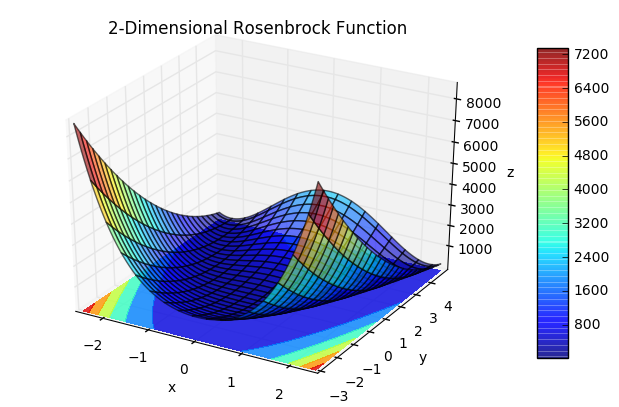

In [5]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
x, y = np.arange(-2.5, 2.5, 3e-2), np.arange(-3.0, 5.0, 3e-2)
x, y = np.meshgrid(x, y)
z = rosenbrock(np.array([x, y]))
surf=ax.plot_surface(x, y, z,cmap=cm.jet, alpha=0.6)
ax.contourf(x, y, z, offset=-200, cmap=cm.jet, alpha=0.8)
fig.colorbar(surf, shrink=0.8, aspect=10)
ax.set_title("2-Dimensional Rosenbrock Function")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

We also give the gradient, hessian and hessian vector product of Rosenbrock function. They are used for derivative based optimizations. In practice, however, a function's derivatives may be very difficult (if not impossible) to compute analytically, in such case, one might consider using AD to evaluate derivatives of the function.

In [6]:
# We can also import these functions directly from scipy.optimize using
# from scipy.optimize import rosen, rosen_der, rosen_hess, rosen_hess_prod

def rosenbrock_grad(x):
    """Gradient of Rosenbrock function"""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def rosenbrock_hess(x):
    """Hessian of Rosenbrock function"""
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

def rosenbrock_hess_vector(x, p):
    """Hessian Vector Product of Rosenbrock function"""
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1]-400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

## Using Gradient Descent Method

In [7]:
# Initial guess (to be used in the following methods)
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

#### Using Analytical Gradient

In [8]:
gd = Grad_Descent()
ad = AD(rosenbrock)
# To find proper step size, number of iterations and precesions for Rosenbrock function can be challenging
gd.minimize(rosenbrock, rosenbrock_grad, x0, step=1e-3, iterations=1e5, precision=1e-10)

array([ 0.99999999,  0.99999998,  0.99999996,  0.99999991,  0.99999983])

In [9]:
print(gd.msg)

Optimization Stop Reason: Precision is reached


As shown below, it only takes gradient descent method a few number of iterations to have a sharp decline in function value, but it takes much more iterations for it to approach 0. Actually, any value greater than the step size we chose ($1e-3$) may easily lead to an overshoot of the problem(i.e., the gradient descent method would diverge), and any value less than the step size we chose may require much more number of iterations and much longer time to carry out the optimization.

The reason that gradient descent method fails to find the optimum of Rosenbrock function efficiently is because the search path of gradient descent method always uses orthogonal direction, however, such direction may lead to a zigzag path that takes a baby step each iteration in a very flat valley. See [Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent#Examples) for a graphical explanation.

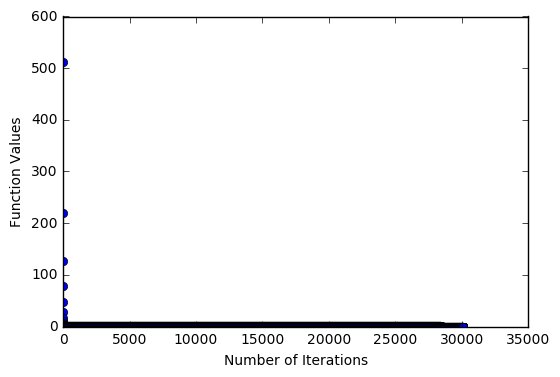

In [10]:
gd.converge_plot()

#### Estimating Gradient Using Finite Differences

In [11]:
def grad_num(x, f, d):
    """Compute gradient numerically via central difference"""
    grad = np.zeros_like(x)
    for k in range(len(x)):
        up, down = x.copy(), x.copy()
        up[k], down[k] = up[k] + d, down[k] - d
        grad[k]= (f(up)-f(down)) / (2*d)
    return grad

In [12]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, lambda x: grad_num(x, rosenbrock, 1e-8), x0, step=1e-3, iterations=1e5, precision=1e-10)

array([ 0.99999999,  0.99999998,  0.99999996,  0.99999991,  0.99999983])

#### Estimating Gradient Using Automatic Differentiation (Forward Mode)

In [13]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, ad.grad_forward, x0, step=1e-3, iterations=1e5, precision=1e-10)

array([ 0.99999999,  0.99999998,  0.99999996,  0.99999991,  0.99999983])

#### Estimating Gradient Using Automatic Differentiation (Reverse Mode)

In [14]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, ad.grad_reverse, x0, step=1e-3, iterations=1e5, precision=1e-10)

array([ 0.99999999,  0.99999998,  0.99999996,  0.99999991,  0.99999983])

## Using Nelder-Mead Simplex Method (Derivative Free Optimization)

In [15]:
res = minimize(rosenbrock, x0, method='nelder-mead', options={'xtol': 1e-8})
res.x

array([ 1.,  1.,  1.,  1.,  1.])

## Using BFGS Method

#### Using Analytical Gradient

In [16]:
res = minimize(rosenbrock, x0, method='BFGS', jac=rosenbrock_grad)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

#### Estimating Gradient Using Finite Differences

In [17]:
# If jac is False, the gradient will be estimated numerically
res = minimize(rosenbrock, x0, method='BFGS', jac=False)
res.x

array([ 0.99999925,  0.99999852,  0.99999706,  0.99999416,  0.99998833])

#### Estimating Gradient Using Automatic Differentiation (Forward Mode)

In [18]:
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='BFGS', jac=ad.grad_forward)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

#### Estimating Gradient Using Automatic Differentiation (Reverse Mode)

In [19]:
res = minimize(rosenbrock, x0, method='BFGS', jac=ad.grad_reverse)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

## Using Newton-Conjugate-Gradient Method (Based on Hessian)

#### Using Analytical Hessian

In [20]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, hess=rosenbrock_hess, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian (Vector Product) Using Finite Differences

In [21]:
# Jacobian is required for Newton-CG method
# If neither hess nor hessp is provided, then the Hessian product will be approximated using finite differences on jac
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, options={'xtol': 1e-8})
res.x

array([ 1.,  1.,  1.,  1.,  1.])

#### Estimating Hessian Using Automatic Differentiation (Forward Mode)

In [22]:
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_forward, hess=ad.hess_forward, options={'xtol': 1e-8})
res.x

/Users/dongmingliu/anaconda/lib/python3.5/site-packages/algopy/utpm/utpm.py:1798: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  S = numpy.zeros((N,M), dtype=x.dtype)


array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Using Automatic Differentiation (Reverse Mode)

In [23]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_reverse, hess=ad.hess_reverse, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

## Using Newton-Conjugate-Gradient Method (Based on Hessian Vector Product)

To quote from `SciPy` documentation: *"For larger minimization problems, storing the entire Hessian matrix can consume considerable time and memory. The Newton-CG algorithm only needs the product of the Hessian times an arbitrary vector ... If possible, using Newton-CG with the Hessian product option is probably the fastest way to minimize the function"*.

#### Using Analytical Hessian Vector Product

In [24]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, hessp=rosenbrock_hess_vector, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Vector Product Using Automatic Differentiation (Forward Mode)

In [25]:
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_forward, hessp=ad.hess_vector_forward, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Vector Product Using Automatic Differentiation (Reverse Mode)

In [26]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_reverse, hessp=ad.hess_vector_reverse, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

## Other Test Function for Optimization: Bird Function

Unlike a plain Rosenbrock function, the Bird function is constrained and has a few local optima. To find its global minimum, we use the global optimization method `basinhopping` along with contraint method `Sequential Least SQuares Programming` as internal minimizer. Specifically, the bird problem is formularized as

$$
\begin{align}
    \min_{x_1, x_2} \quad & f(x_1, x_2) = {\sin(x_1)}{e}^{\bigl(1-\cos(x_2)\big)^2} + {\cos(x_2)}{e}^{\bigl(1-\sin(x_1)\big)^2} + (x_1-x_2)^2 \\
    \textrm{s.t.} \quad & (x_1+5)^2 + (x_2+5)^2 \geq 25 \\
                        & -6 \leq x_1 \leq 6 \\ 
                        & -6 \leq x_2 \leq 6 \\ 
\end{align}
$$

with global optimum located at $(4.7, 3.15)$.

In [27]:
bird = lambda x: algopy.sin(x[0])*algopy.exp(1-algopy.cos(x[1]))**2 + algopy.cos(x[1])*algopy.exp(1-algopy.sin(x[0]))**2 + (x[0]-x[1])**2

/Users/dongmingliu/anaconda/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


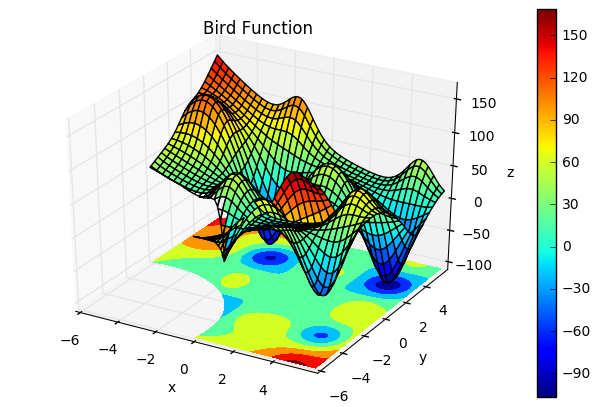

In [28]:
fig = plt.figure(figsize=(8, 5))
ax = fig.gca(projection='3d')
x = np.arange(-6, 6, 3e-2)
y = np.arange(-6, 6, 3e-2)
x, y = np.meshgrid(x, y)
r2 = (x+5)**2 + (y+5)**2
scope = r2 < 25
x[scope] = np.nan
y[scope] = np.nan
z = bird(np.array([x, y]))
norm = matplotlib.colors.Normalize(vmin=min(z[~np.isnan(z)]), vmax=max(z[~np.isnan(z)]))
cm.jet.set_under(color="none")
ax.contourf(x, y, z, offset=-110, cmap=cm.jet, norm=norm)
surf=ax.plot_surface(x, y, z, cmap=cm.jet, norm=norm)
fig.colorbar(surf)
ax.set_title("Bird Function")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [29]:
# Constraint and constraint's gradient used in the SLSQP minimizer
constraint = lambda x: (x[0] + 5)**2 + (x[1] + 5)**2 - 25
constraint_grad = lambda x: AD(constraint).grad_reverse(x)
cons = ({'type': 'ineq', 'fun' : constraint, 'jac' : constraint_grad},)
# Optimization
ad = AD(bird)
x0 = [-1.0,-5.0]
minimizer_kwargs = {'method': 'SLSQP', 'jac': ad.grad_reverse, 'constraints': cons, 'bounds': ((-6.0, 6.0),(-6.0, 6.0))}
res = basinhopping(bird, x0, minimizer_kwargs=minimizer_kwargs, niter=1000)
res.x

array([ 4.69365649,  3.16032515])